<a href="https://colab.research.google.com/github/dookda/cmu_udfire_gee/blob/main/prediction_hotspot_lstm_predicted_for2025_colab_multifactor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

ee.Authenticate()
try:
    ee.Initialize(project="ee-sakda-451407")
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project="ee-sakda-451407")

In [2]:
study_area = ee.FeatureCollection("projects/ee-sakda-451407/assets/fire/khunyoam_sub") \
               .geometry().bounds()
date_start = ee.Date('2020-01-01')
date_end   = ee.Date('2024-12-31')

# 1) Hotspot points as before
firms = ee.ImageCollection('FIRMS')\
    .select('confidence')\
    .filterDate(date_start, date_end)\
    .filterBounds(study_area)

def create_fire_points(image):
    fire_mask = image.select('confidence').gt(80)\
        .set('system:time_start', image.get('system:time_start'))
    vectors = fire_mask.reduceToVectors(
        geometry=study_area,
        scale=375,
        geometryType='centroid',
        labelProperty='fire',
        maxPixels=1e9
    ).filterBounds(study_area)
    return vectors.map(lambda feature: feature.set('system:time_start', image.get('system:time_start')))

fire_points = firms.map(create_fire_points)
fire_pts = fire_points.flatten()

# 2) CHIRPS daily rainfall (unchanged)
rainfall = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')\
    .select('precipitation')\
    .filterDate(date_start, date_end)\
    .filterBounds(study_area)

# 3) MODIS 8-day surface reflectance → compute NDVI
sr8 = ee.ImageCollection('MODIS/061/MOD09A1')\
    .select(['sur_refl_b02','sur_refl_b01'])\
    .filterDate(date_start, date_end)\
    .filterBounds(study_area)

def compute_ndvi(img):
    ndvi = img.normalizedDifference(['sur_refl_b02','sur_refl_b01']) \
              .rename('NDVI') \
              .copyProperties(img, ['system:time_start'])
    return ndvi

ndvi8 = sr8.map(compute_ndvi)

# 4) Build 8-day periods instead of weeks
#    total number of 8-day blocks in your range:
numPeriods = date_end.difference(date_start, 'day').divide(8).floor()
periods = ee.List.sequence(0, numPeriods)

def count_period(i):
    i = ee.Number(i)
    start = date_start.advance(i.multiply(8), 'day')
    end   = start.advance(8, 'day')

    # … hotspot as before …
    hs = fire_pts.filterDate(start, end).size()

    # rainfall: use dict.get('precipitation', 0)
    rain_dict = rainfall.filterDate(start, end).sum().reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=study_area,
        scale=1000,
        bestEffort=True
    )
    rain_val = ee.Number(rain_dict.get('precipitation', 0))

    # NDVI: same pattern, default to 0 if missing
    nd_dict = ndvi8.filterDate(start, end).mean().reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=study_area,
        scale=500,
        bestEffort=True
    )
    nd_val = ee.Number(nd_dict.get('NDVI', 0))

    return ee.Feature(None, {
        'period_start': start.format('YYYY-MM-dd'),
        'hotspot':      hs,
        'rainfall':     rain_val,
        'ndvi':         nd_val
    })

fc8 = ee.FeatureCollection(periods.map(count_period))

# 5) Bring into Python and build DataFrame
features = fc8.getInfo()['features']
df = pd.DataFrame([{
    'week':     f['properties']['period_start'],
    'hotspot':  f['properties']['hotspot'],
    'rainfall': f['properties']['rainfall'],
    'ndvi':     f['properties']['ndvi']
} for f in features])

df['week'] = pd.to_datetime(df['week'])
df = df.set_index('week').sort_index().astype(float).fillna(0)

# 6) Add your month_sin/month_cos in pandas
df['month']     = df.index.month
df['month_sin'] = np.sin(2*np.pi*df.month/12)
df['month_cos'] = np.cos(2*np.pi*df.month/12)


In [3]:
fire_pts = fire_points.flatten()
def add_ee_layer(ee_object, vis_params, name, opacity=0.5):
    try:
        if isinstance(ee_object, ee.Image):
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
        elif isinstance(ee_object, ee.Geometry):
            map_id_dict = ee.Feature(ee_object).getMapId(vis_params)
        elif isinstance(ee_object, ee.FeatureCollection):
            map_id_dict = ee.FeatureCollection(ee_object).getMapId(vis_params)
        folium.TileLayer(
            tiles=map_id_dict['tile_fetcher'].url_format,
            attr='Google Earth Engine',
            name=name,
            opacity=opacity,
            overlay=True,
            control=True
        ).add_to(m)
    except Exception as e:
        print(f"Error adding {name} layer: {e}")

f = folium.Figure(height=400)
m = folium.Map(location=[18.6700, 100.5925], zoom_start=10).add_to(f)

folium.TileLayer(
    tiles='https://mt0.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google',
    name='Google Satellite',
    overlay=False,
    control=True
).add_to(m)

add_ee_layer(study_area, {'color': 'yellow'}, 'Thailand Boundary', 0.3)
add_ee_layer(fire_pts, {'color': 'red'}, 'FIRMS Hotspots', 1.0)
m.add_child(folium.LayerControl())

bnd = study_area.bounds().getInfo()
south_west = bnd['coordinates'][0][0]
north_east = bnd['coordinates'][0][2]

bounds = [south_west, north_east]
flipped = [pt[::-1] for pt in bounds]
print(flipped)
m.fit_bounds(flipped)
# m.save('thailand_hotspots.html')
m

[[18.859179266479572, 97.81078735680417], [19.057895876907995, 97.9793592550395]]


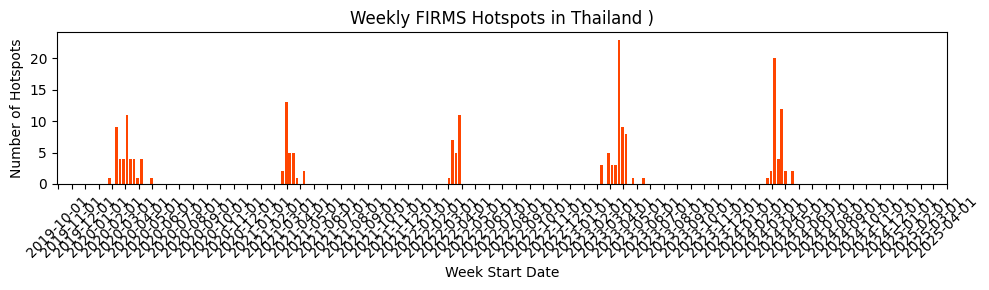

In [4]:
plt.figure(figsize=(10, 3))
plt.bar(df.index, df['hotspot'], width=6, color='#ff4500', align='center')
plt.title('Weekly FIRMS Hotspots in Thailand )')
plt.xlabel('Week Start Date')
plt.ylabel('Number of Hotspots')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('weekly_hotspot_counts_2024.png')
plt.show()

In [5]:
features = ['hotspot'] #'hotspot','month_sin','month_cos','rainfall','ndvi'
print(df[features].head(5))

data = df[features].values
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

def create_sequences(data, seq_len):
    Xs, ys = [], []
    for i in range(len(data) - seq_len):
        Xs.append(data[i:i+seq_len])
        ys.append(data[i+seq_len, 0])
    return np.array(Xs), np.array(ys)

sequence_length = 53
X, y = create_sequences(scaled, sequence_length)
X = X.astype('float32')
y = y.astype('float32')

n_features = X.shape[-1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False
)

X_train, X_test = X_train.astype('float32'), X_test.astype('float32')
y_train, y_test = y_train.astype('float32'), y_test.astype('float32')

            hotspot
week               
2020-01-01      0.0
2020-01-09      0.0
2020-01-17      0.0
2020-01-25      1.0
2020-02-02      0.0


In [ ]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, n_features), return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    verbose=0)

In [6]:
model = Sequential([
    Bidirectional(LSTM(128, activation="tanh", return_sequences=True, kernel_regularizer=l2(1e-4)), input_shape=(sequence_length, n_features)),
    Dropout(0.4),
    LSTM(64, activation="tanh"),
    Dropout(0.4),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    verbose=0,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 53, 256)        │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 53, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 215,361 (841.25 KB)

 Trainable params: 215,361 (841.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model = Sequential([
    LSTM(128, activation="tanh", return_sequences=True, input_shape=(sequence_length, n_features)),
    Dropout(0.3),
    LSTM(64, activation="tanh"),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=8,
    validation_split=0.2,
    verbose=0,
    callbacks=[early_stopping]
)

In [ ]:
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-4)),
                  input_shape=(sequence_length, n_features)),
    Dropout(0.4),
    LSTM(32, kernel_regularizer=l2(1e-4)),
    Dropout(0.4),
    Dense(1)
])
model.compile(optimizer=Adam(1e-3), loss='mse')
model.summary()

history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=100,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=0
)

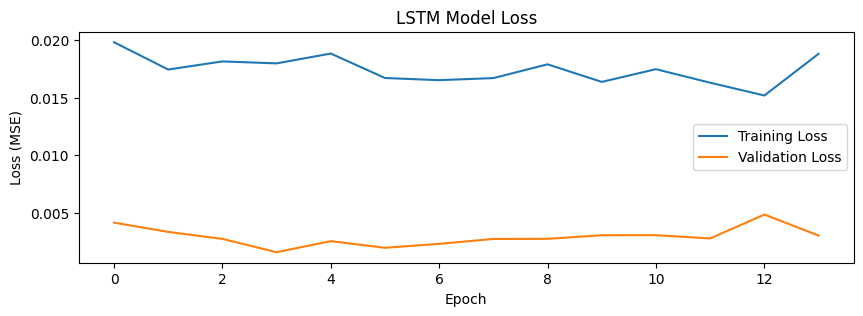

In [7]:
plt.figure(figsize=(10, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
# plt.savefig('lstm_training_loss.png')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
MSE: 8.85, MAE: 1.21, R2: 0.13


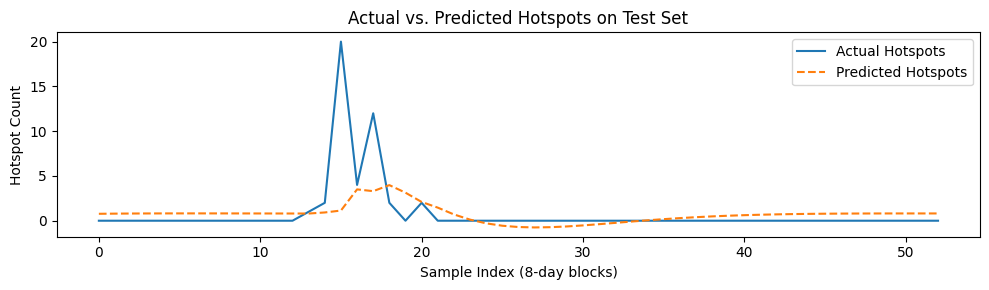

In [8]:
y_pred_norm = model.predict(X_test).flatten()   # shape = (n_test,)
y_test_norm = y_test                            # shape = (n_test,)

hot_min   = scaler.data_min_[0]
hot_max   = scaler.data_max_[0]
hot_rng   = hot_max - hot_min

y_pred   = y_pred_norm * hot_rng + hot_min
y_actual = y_test_norm * hot_rng + hot_min

mse = mean_squared_error(y_actual, y_pred)
mae = mean_absolute_error(y_actual, y_pred)
r2  = r2_score(y_actual, y_pred)
print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")

plt.figure(figsize=(10, 3))
plt.plot(y_actual, label='Actual Hotspots')
plt.plot(y_pred,   label='Predicted Hotspots', linestyle='--')
plt.title('Actual vs. Predicted Hotspots on Test Set')
plt.xlabel('Sample Index (8-day blocks)')
plt.ylabel('Hotspot Count')
plt.legend()
plt.tight_layout()
plt.show()

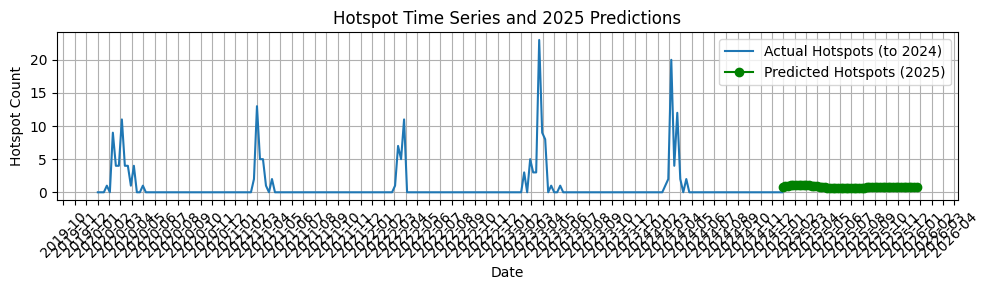

Total FIRMS Hotspots in Study Area (2020–2024): 194
Total Predicted Hotspots in 2025: 41


In [9]:
# 1) สร้าง scaler สำหรับเฉพาะคอลัมน์ hotspot
hotspot_scaler = MinMaxScaler()
hotspot_scaler.fit(df[['hotspot']])

# 2) Normalize ประวัติ hotspot
hotspot_norm = hotspot_scaler.transform(df[['hotspot']])

# 3) เตรียม sequence
current_seq = hotspot_norm[-sequence_length:].reshape(1, sequence_length, 1)
future_norm = []

# 4) ทำนาย 52 ช่วง
for _ in range(52):
    pred_norm = model.predict(current_seq, verbose=0)
    future_norm.append(pred_norm[0,0])
    # เลื่อน window ขึ้น 1 และต่อด้วยค่าที่ทำนาย
    current_seq = np.concatenate([
        current_seq[:,1:,:],
        pred_norm.reshape(1,1,1)
    ], axis=1)

# 5) Inverse-scale ผลลัพธ์
predicted_2025 = hotspot_scaler.inverse_transform(
    np.array(future_norm).reshape(-1,1)
).flatten()

# 6) สร้าง index วันที่ (จันทร์ของแต่ละสัปดาห์)
last_date = df.index[-1]
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=52,
    freq='W-MON'
)

# 7) สร้าง Series เพื่อง่ายต่อการ plot
actual_series = pd.Series(df['hotspot'].values, index=df.index)
pred_series   = pd.Series(predicted_2025, index=future_dates)

# 8) Plot Time Series + Forecast
plt.figure(figsize=(10,3))
plt.plot(actual_series, label='Actual Hotspots (to 2024)')
plt.plot(pred_series, 'go-', label='Predicted Hotspots (2025)')
plt.xlabel('Date')
plt.ylabel('Hotspot Count')
plt.title('Hotspot Time Series and 2025 Predictions')
plt.legend()
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 9) สรุปผลรวม
total_hist = int(df['hotspot'].sum())
print(f"Total FIRMS Hotspots in Study Area (2020–2024): {total_hist}")

# ยอดคาดการณ์ปี 2025
total_pred_2025 = int(predicted_2025.sum())
print(f"Total Predicted Hotspots in 2025: {total_pred_2025}")

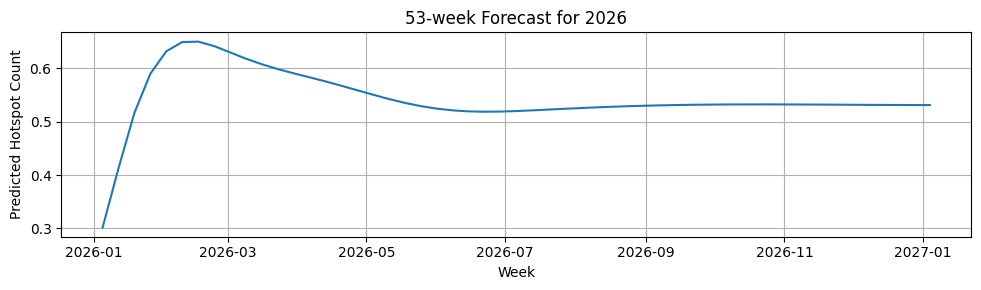

In [65]:
next_year = (pd.to_datetime(df['date']).dt.year.max() + 1) if 'date' in df.columns else 2026
n_weeks = 53

# 2) Seed sequence: last 'sequence_length' timesteps from your scaled series
last_seq = scaled[-sequence_length:, :].copy()  # shape: (seq_len, n_features)

# 3) Iterative one-step-ahead predictions (feed previous prediction back as input)
preds_norm = []
seq = last_seq.copy()
for _ in range(n_weeks):
    x = seq.reshape(1, sequence_length, n_features)
    yhat = model.predict(x, verbose=0)[0, 0]  # normalized space
    preds_norm.append(yhat)
    # roll window: drop first row, append the new prediction as next row
    seq = np.vstack([seq[1:], [yhat] if n_features == 1 else [np.r_[yhat, seq[-1,1:]]]])

preds_norm = np.array(preds_norm)

# 4) Inverse scale back to hotspot counts
hot_min = scaler.data_min_[0]
hot_max = scaler.data_max_[0]
hot_rng = hot_max - hot_min
preds = preds_norm * hot_rng + hot_min

# 5) Build weekly dates for the next year (choose anchor weekday as needed)
start_date = pd.Timestamp(f"{int(next_year)}-01-01")
# Align to Mondays; adjust to 'W-SUN' or 'W-THU' if you prefer another anchor
dates = pd.date_range(start=start_date, periods=n_weeks, freq="W-MON")

forecast_53w = pd.DataFrame({
    "date": dates,
    "pred_hotspot": preds.astype(float)
})

# Save
# out_csv = "/mnt/data/forecast_next_year_53w.csv"
# forecast_53w.to_csv(out_csv, index=False)
# print("Saved 53-week forecast to:", out_csv)

# (Optional) Quick plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.plot(forecast_53w['date'], forecast_53w['pred_hotspot'])
plt.title(f"53-week Forecast for {int(next_year)}")
plt.xlabel("Week")
plt.ylabel("Predicted Hotspot Count")
plt.grid(True)
plt.tight_layout()
plt.show()